# Simulation experiment

**Hypothesis**: If we generate a gene expression dataset with a strong signal, a nonlinear compression method (VAE)
            will be able to learn this signal and predict new gene expression patterns better compared to 
            using a linear comparession method (PCA) and using no compression method (all the genes)
 
**Study design**:

*(Input)* Add signal to Pa gene expression dataset:

Network: gene set A --> gene set B

Add signal to relate A and B using the following algorithm:

Hyperparmeters should include:
 1. Size of gene set A
 2. Size of gene set B
 3. Effect size
 4. Threshold
 5. Log file with hyperparameter selections
         
*(Approach)* Train nonlinear (VAE) and linear (PCA) compression algorithms using this simulated data

*(Evaluation)*  For each sample in the Pa dataset compare corr(predicted expression, actual expression)

*(Output)* Figure of the correlation scores per sample 

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import seaborn as sns

from functions import generate_input, vae, def_offset, interpolate, pca, plot

from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# Hyperparameters

# Size of the gene set A
geneSetA_size = 100

# Size of the gene set that will be regulated by gene A
geneSetB_size = 1000 

# Percentage to upregulate each gene in set B
effect_size = 0.5

# Threshold for activation of gene A 
thresholdA = 0.5

# Name of analysis
analysis_name = 'sim_AB_2775_300_v2'

In [3]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")

In [4]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# Randomly select genes for set A
gene_ids = list(data.columns)
geneSetA = random.sample(gene_ids, geneSetA_size)

In [6]:
# checkpoint:  Check the number of genes
assert(len(gene_ids)==5549)
print("Confirmed that all gene ids are available")

Confirmed that all gene ids are available


In [7]:
# Remove gene ids that were selected for gene set A
gene_ids = [elem for elem in gene_ids if elem not in geneSetA]
print("After removing {} gene ids for set A, there are {} gene ids remaining."
      .format(geneSetA_size, len(gene_ids)))

After removing 100 gene ids for set A, there are 5449 gene ids remaining.


In [8]:
# Randomly select genes for gene set B
geneSetB = random.sample(gene_ids, geneSetB_size)

# Remove gene ids that were selected for gene set B
gene_ids = [elem for elem in gene_ids if elem not in geneSetB]
print("After removing {} gene ids for set B, there are {} gene ids remaining."
      .format(geneSetB_size, len(gene_ids)))

After removing 1000 gene ids for set B, there are 4449 gene ids remaining.


In [9]:
# checkpoint:  Check that genes in set A are distinct from genes in set B
assert(len(set(geneSetA).intersection(set(geneSetB))) == 0)

## Output gene groupings 
Output gene assignments (group A, B) to be used in [explore_simulated_data.py](explore_simulated_data.ipynb)

In [10]:
# Output gene groupings
geneSetA_df = pd.DataFrame(geneSetA)
geneSetB_df = pd.DataFrame(geneSetB)

geneSetA_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetA.txt")
geneSetB_file = os.path.join(os.path.dirname(os.getcwd()), "data", analysis_name, "geneSetB.txt")


geneSetA_df.to_csv(geneSetA_file, sep='\t')
geneSetB_df.to_csv(geneSetB_file, sep='\t')

## Add artificial signal to the data
Algorithm:
```python
for sample in compendium:
    expression(gene_in_set_A) = random(0,1)
    if expression(gene_in_set_A) > threshold_A:
        expression(gene_in_set_B) = expression(gene_in_set_B)*(1+percentage) 
```
Note: This algorithm is applied to each sample in the compendium 
      (essentially adding a signal to the existing gene expression data in the compendium)

In [11]:
# Number of samples 
num_samples = data.shape[1]

# Select sample gene from set A to be representative since the expression is the same
# for all genes in the set
geneSetA_pick = geneSetA[0]

# Loop through all samples
for sample_id in data.index:
    
    # Randomly select a value [0,1] where each value is uniformly likely to be chosen
    new_A_exp = random.uniform(0.0, 1.0)
    
    # Set gene expression value for genes in set A to be the same random value selected
    data.loc[sample_id][geneSetA] = new_A_exp
    
    # Check if expression of genes in set A exceed the threshold
    # Use representatve gene from set A "geneSetA_pick" selected above
    if data.loc[sample_id,geneSetA_pick] > thresholdA:
        
        # Scale genes by some fixed percentage
        for gene in geneSetB:
            data.loc[sample_id,gene] = (1+effect_size)*data.loc[sample_id,gene]            
            
# if any exceed 1 then set to 1 since gene expression is normalized
data[data>=1.0] = 1.0

In [12]:
# Dataframe with only gene A expression
# Used in interpolation analysis
geneA_only = pd.DataFrame(data[geneSetA_pick], index=data.index, columns=[geneSetA_pick])

geneA_only.head()

,PA3423
0.1_12hr_CSV86(Pae_G1a).CEL,0.417736
0.1_2hr_CSV86(Pae_G1a).CEL,0.980972
0.1_6hr_CSV86(Pae_G1a).CEL,0.090807
0.1_7hr_CSV86(Pae_G1a).CEL,0.837731
0.1_9hr_CSV86(Pae_G1a).CEL,0.850805


In [13]:
# Create list of base directories
base_dirs = [os.path.join(os.path.dirname(os.getcwd()), 'data'),
             os.path.join(os.path.dirname(os.getcwd()), 'encoded'),
             os.path.join(os.path.dirname(os.getcwd()), 'models'),
             os.path.join(os.path.dirname(os.getcwd()), 'output'),
             os.path.join(os.path.dirname(os.getcwd()), 'stats'),
             os.path.join(os.path.dirname(os.getcwd()), 'viz')    
]

# Check if directory exist otherwise create
for each_dir in base_dirs:
    analysis_dir = os.path.join(each_dir, analysis_name)
    
    if os.path.exists(analysis_dir):
        print('directory already exists: {}'.format(analysis_dir))
    else:
        print('creating new directory: {}'.format(analysis_dir))
    os.makedirs(analysis_dir, exist_ok=True)

directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/data/sim_AB_2775_300_v2
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/encoded/sim_AB_2775_300_v2
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/models/sim_AB_2775_300_v2
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/output/sim_AB_2775_300_v2
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/stats/sim_AB_2775_300_v2
directory already exists: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/viz/sim_AB_2775_300_v2


## Outputs
Output
1. Simulated dataset (\data)
2. Log file containing hyperparmeters used (\metadata)
3. Expression of representative gene from group A (\data)

In [14]:
# Output the new gene expression values for each sample
train_input_file = os.path.join(base_dirs[0], analysis_name, "train_model_input.txt.xz")
data.to_csv(train_input_file, sep='\t', compression='xz', float_format="%.5g")

# Output log file with parameters used to generate simulated data
log_file = os.path.join(os.path.dirname(os.getcwd()), 'metadata', analysis_name + '_log.txt')

args_dict = {
    "size of gene set A": geneSetA_size,
    "size of gene set B": geneSetB_size,
    "genes in set B": geneSetB,
    "effect size of genes in set B": effect_size,
    "threshold of A activation": thresholdA,
}

with open(log_file, 'w') as f:
    for key, value in args_dict.items():
        f.write('%s: %s\n' % (key, value))
        
# Output geneA only file using sample gene A selected
geneA_file = os.path.join(base_dirs[0], analysis_name, geneSetA_pick + ".txt")
geneA_only.to_csv(geneA_file, sep='\t', float_format="%.5g")

## Train 
Train compression methods (VAE, PCA) using simulated data

/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/vae.py:206: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


Train on 1072 samples, validate on 119 samples
Epoch 1/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3625.0793 - val_loss: 3911.4382
Epoch 2/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3449.7842 - val_loss: 3626.2825
Epoch 3/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3412.3977 - val_loss: 3452.5305
Epoch 4/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3387.7922 - val_loss: 3425.3148
Epoch 5/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3370.7417 - val_loss: 3409.2791
Epoch 6/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3356.3183 - val_loss: 3403.1342
Epoch 7/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3349.6360 - val_loss: 3371.0626
Epoch 8/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3343.0249 - val_loss: 3366.5338
Epoch 9/200
1072/1072 [==============================] - 12s 12ms

Epoch 74/200
1072/1072 [==============================] - 12s 12ms/step - loss: 3206.5079 - val_loss: 3265.3245
Epoch 75/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3206.3744 - val_loss: 3265.0142
Epoch 76/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3206.0794 - val_loss: 3260.2602
Epoch 77/200
1072/1072 [==============================] - 12s 12ms/step - loss: 3204.7883 - val_loss: 3264.3184
Epoch 78/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3204.1208 - val_loss: 3261.2938
Epoch 79/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3203.3620 - val_loss: 3259.3503
Epoch 80/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3203.5507 - val_loss: 3264.9374
Epoch 81/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3203.1809 - val_loss: 3262.6492
Epoch 82/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3201.5900 - val_loss: 32

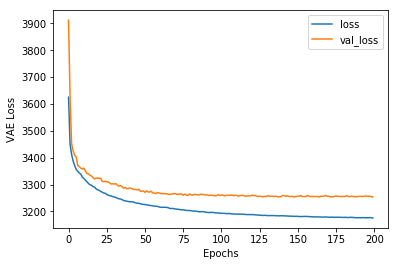

In [15]:
%%time
# Parameters to train nonlinear (VAE) compression method
learning_rate = 0.001
batch_size = 100
epochs = 200
kappa = 0.01
intermediate_dim = 2775
latent_dim = 300
epsilon_std = 1.0
num_PCs = latent_dim

base_dir = os.path.dirname(os.getcwd())

# Train nonlinear (VAE)
vae.tybalt_2layer_model(learning_rate, batch_size, epochs, kappa, intermediate_dim,
                        latent_dim, epsilon_std, base_dir, analysis_name)
# Train linear (PCA)
pca.pca_model(base_dir, analysis_name, num_PCs)

## Prediction
Predict gene expression for each sample in the compendium

Details about how the prediction computation works can be found within the prediction script: [interpolate.py](/functions/interpolate.py)

Algorithm:
```python
sort samples based on gene A expression

for sample in compendium:
    baseline_expression = expression(sample with low gene A expression)
    offset_vector = (expression(high gene A expression) - expression(low gene A expression)
    scale_factor = expression(sample)/((expression(high gene A expression) - expression(low gene A expression))
    predict_expression = baseline_expression + scale_factor*offset_vector 
```

In [16]:
# Prediction based calculation described in interpolate.py

# Define offset vectors in gene space
data_dir = os.path.join(base_dirs[0], analysis_name)
target_gene = geneSetA_pick
percent_low = 5
percent_high = 95

def_offset.gene_space_offset(data_dir, target_gene, percent_low, percent_high)

model_dir = os.path.join(base_dirs[2], analysis_name)
encoded_dir = os.path.join(base_dirs[1], analysis_name)

# Define offset vectors for VAE latent space
# The offset vector represents the "essence" of gene A
# The offset vector = highest percent_high gene expression - lowest percent_low gene expression  
def_offset.vae_latent_space_offset(data_dir, model_dir, encoded_dir, latent_dim, target_gene, percent_low,
                                   percent_high)
# Define offset vectors for PCA latent space
def_offset.pca_latent_space_offset(data_dir, model_dir, encoded_dir, target_gene, percent_low, percent_high)


# Predict gene expression using offset in gene space and latent space
# Predict sample gene expression = baseline low gene expression + scale factor * offset vector
# interpolate.py returns correlation between predicted expression and actual expression
out_dir = os.path.join(base_dirs[3], analysis_name)

interpolate.interpolate_in_gene_space(data_dir, target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_vae_latent_space(data_dir, model_dir, encoded_dir, latent_dim, 
                                            target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_pca_latent_space(data_dir, model_dir, encoded_dir, target_gene, 
                                            out_dir, percent_low, percent_high)

Number of genes in low expression group is (60, 5549)
Number of gene in high expression group is (60, 5549)


/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of genes in low expression group is (60, 5549)
Number of gene in high expression group is (60, 5549)
Number of genes in low expression group is (60, 5549)
Number of gene in high expression group is (60, 5549)


## Visualize
Visualize prediction performance comparing VAE, PCA, No compression

/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/plot.py:87: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X_sorted = X.loc[sorted_id.index].dropna()


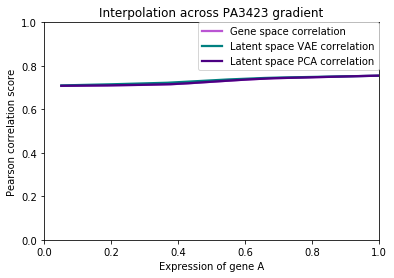

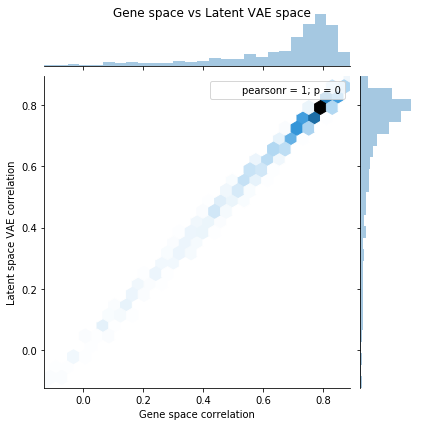

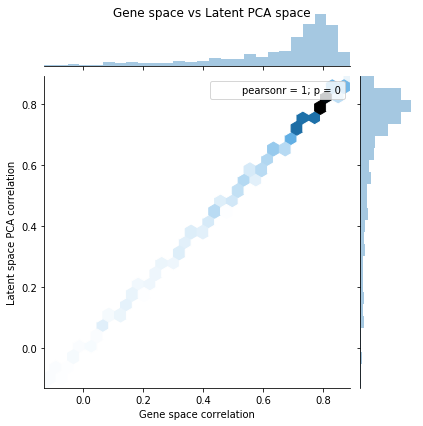

In [17]:
# True if the x-axis of the plot uses the sample index
# False if the x-asix of the plot uses the gene expression of the target gene
by_sample_ind = False

# Plot correlation score per sample along gradient of gene A expression
viz_dir = os.path.join(base_dirs[5], analysis_name)
plot.plot_corr_gradient(out_dir, viz_dir, target_gene, by_sample_ind)